In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [81]:
def preprocess(data, noise_factor=0.4):
    """
    Generates the original data, noisy data pair for training 
    denoising autoencoder
    """

    data = data.astype('float32') / 255.0
    data = np.reshape(data, (len(data), 28, 28, 1))

    # Noisy Data Generation
    noisy_array = data + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=data.shape)

    noisy_array = np.clip(noisy_array, 0.0, 1.0)

    return (data, noisy_array)

In [12]:
def display(arr1, arr2, row, col):
    
    if row * col > len(arr1) or row * col > len(arr2):
        print('Not sufficient data')
        return

    # Ensuring proper length of dimensions
    assert len(arr1) == len(arr2)

    fig, ax = plt.subplots(row, col, dpi=100)

    for i in range(col):
        idx = np.random.choice(len(arr1), replace = False)
        ax[0][i].imshow(arr1[i], cmap='gray')
        ax[1][i].imshow(arr2[i], cmap='gray')
        ax[0][i].axis('off')
        ax[1][i].axis('off')

    plt.plot()

In [92]:
(train_data, _), (test_data, _) = mnist.load_data()

In [93]:
p_train_data, noisy_train_data = preprocess(data=train_data)

p_test_data, noisy_test_data = preprocess(data=test_data)

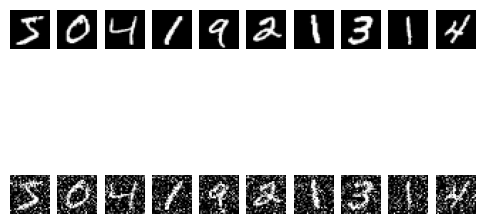

In [94]:
# Displaying Training Data
display(p_train_data, noisy_train_data, 2, 10)

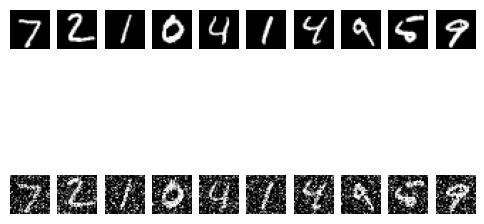

In [95]:
# Displaying Test Data
display(p_test_data, noisy_test_data, 2, 10)

## Training Autoencoder for denoising

In [52]:
class AutoEncoder:
    
    def __init__(self, epochs, batch_size, optimizer, loss):
        
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss = loss
        self.batch_size = batch_size
        
        
    def build(self):
        input_data = layers.Input(shape=(28, 28, 1))

        # Encoder
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_data)
        x = layers.MaxPooling2D((2, 2), padding="same")(x)
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling2D((2, 2), padding="same")(x)

        # Decoder
        x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
        out = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
        
        model = Model(inputs=input_data, outputs=out)
        model.compile(optimizer=self.optimizer, loss=self.loss)
        
        return model
        
    def plot_training(self, history):
        
        fig, ax = plt.subplots(1,1, dpi = 200)
        ax.plot(history.history['loss'], label = 'training_loss')
        ax.plot(history.history['val_loss'], label = 'validation_loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(str(self.loss))
        plt.legend()
        plt.plot()
        
    def plot_model(self, model):
        
        plot_model(model, to_file='autoencoder.png', show_shapes=True)
        
    def predict(self, noisy_test_data, model):
        
        model.load_weights('ae.hdf5')
        y_pred = model.predict(noisy_test_data)
        return y_pred
    
    def print_summary(self, model):
        print(model.summary())

In [49]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [53]:
# Hyper-Parameters
optimizer = 'adam'
epochs = 100
batch_size = 128
loss = 'binary_crossentropy'

In [56]:
autoencoder = AutoEncoder(epochs=epochs, batch_size=batch_size, optimizer=optimizer, loss=loss)

In [64]:
model = autoencoder.build()

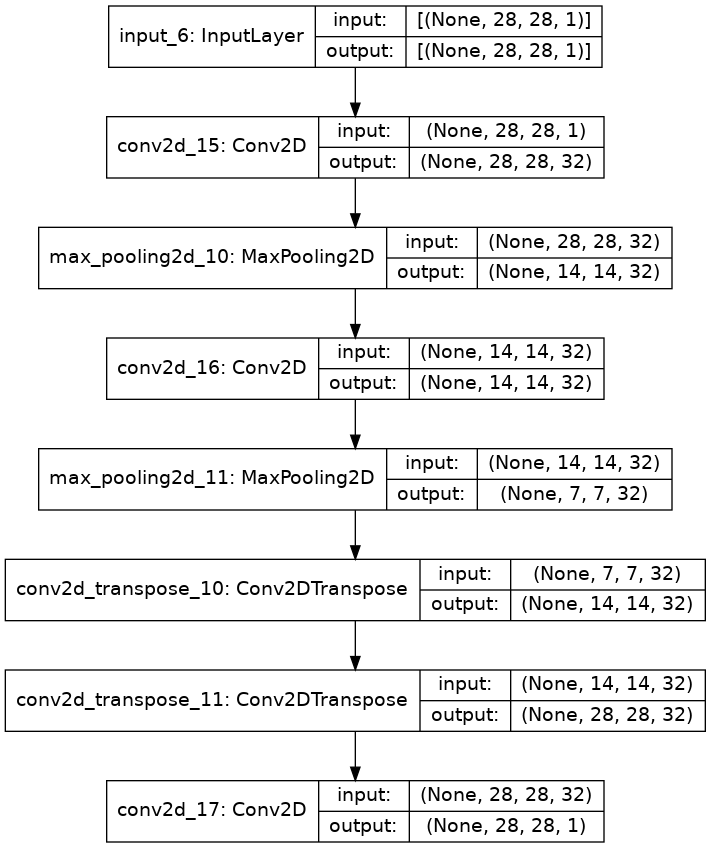

In [58]:
# Plotting Model
autoencoder.plot_model(model)
Image(filename='autoencoder.png')

In [59]:
autoencoder.print_summary(model)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 32)        9248

In [63]:
# Step-1: Train Autoencoder to Reconstruct original input
checkpoint = callbacks.ModelCheckpoint(filepath = 'ae.hdf5', save_weights_only= True,
                                                  save_best_only= True, monitor = 'val_loss', mode = 'min', verbose = 1)
ae_callbacks = [checkpoint]

In [65]:
history = model.fit(
    x=p_train_data,
    y=p_train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(p_test_data, p_test_data),
    callbacks = ae_callbacks
)

Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 0.2407 - val_loss: 0.0735

Epoch 00001: val_loss improved from inf to 0.07346, saving model to ae.hdf5
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0728 - val_loss: 0.0697

Epoch 00002: val_loss improved from 0.07346 to 0.06968, saving model to ae.hdf5
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0698 - val_loss: 0.0681

Epoch 00003: val_loss improved from 0.06968 to 0.06813, saving model to ae.hdf5
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0683 - val_loss: 0.0673

Epoch 00004: val_loss improved from 0.06813 to 0.06725, saving model to ae.hdf5
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0677 - val_loss: 0.0666

Epoch 00005: val_loss improved from 0.06725 to 0.06661, saving model to ae.hdf5
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0669 - val_loss: 0.0661

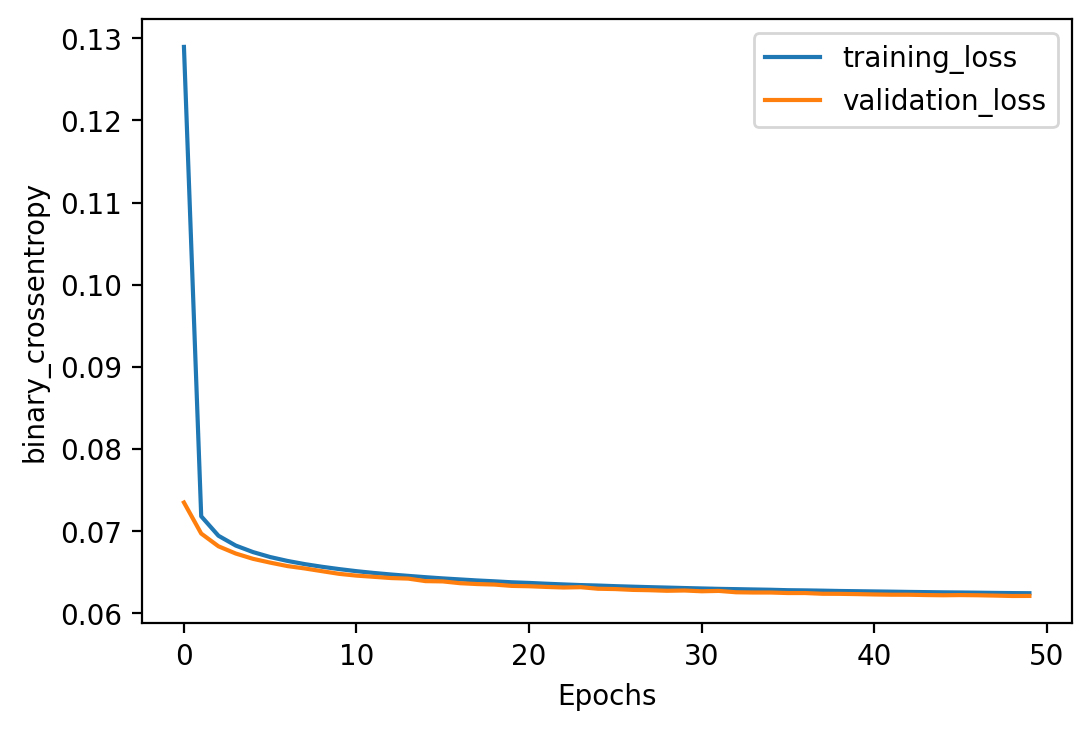

In [66]:
autoencoder.plot_training(history)

**Note:** The above plot shows that the validation loss does not decrease after almost **120** epoch. For prediction we use the best weights attained

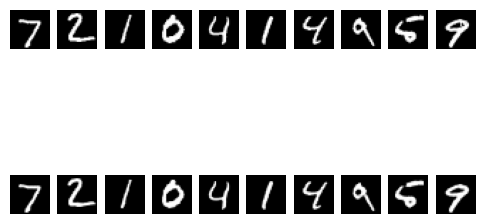

In [67]:
y_pred_orig = autoencoder.predict(p_test_data, model)

display(test_data, y_pred_orig, 2, 10)

In [68]:
# Fine-tuning for noisy data
checkpoint = callbacks.ModelCheckpoint(filepath = 'ae.hdf5', save_weights_only= True,
                                                  save_best_only= True, monitor = 'val_loss', mode = 'min', verbose = 1)
ae_callbacks = [checkpoint]
history = model.fit(
    x=noisy_train_data,
    y=p_train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, p_test_data),
    callbacks = ae_callbacks
)

Epoch 1/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1021 - val_loss: 0.0945

Epoch 00001: val_loss improved from inf to 0.09455, saving model to ae.hdf5
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0940 - val_loss: 0.0921

Epoch 00002: val_loss improved from 0.09455 to 0.09214, saving model to ae.hdf5
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0921 - val_loss: 0.0908

Epoch 00003: val_loss improved from 0.09214 to 0.09081, saving model to ae.hdf5
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0910 - val_loss: 0.0899

Epoch 00004: val_loss improved from 0.09081 to 0.08993, saving model to ae.hdf5
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0902 - val_loss: 0.0893

Epoch 00005: val_loss improved from 0.08993 to 0.08927, saving model to ae.hdf5
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0896 - val_loss: 0.0890

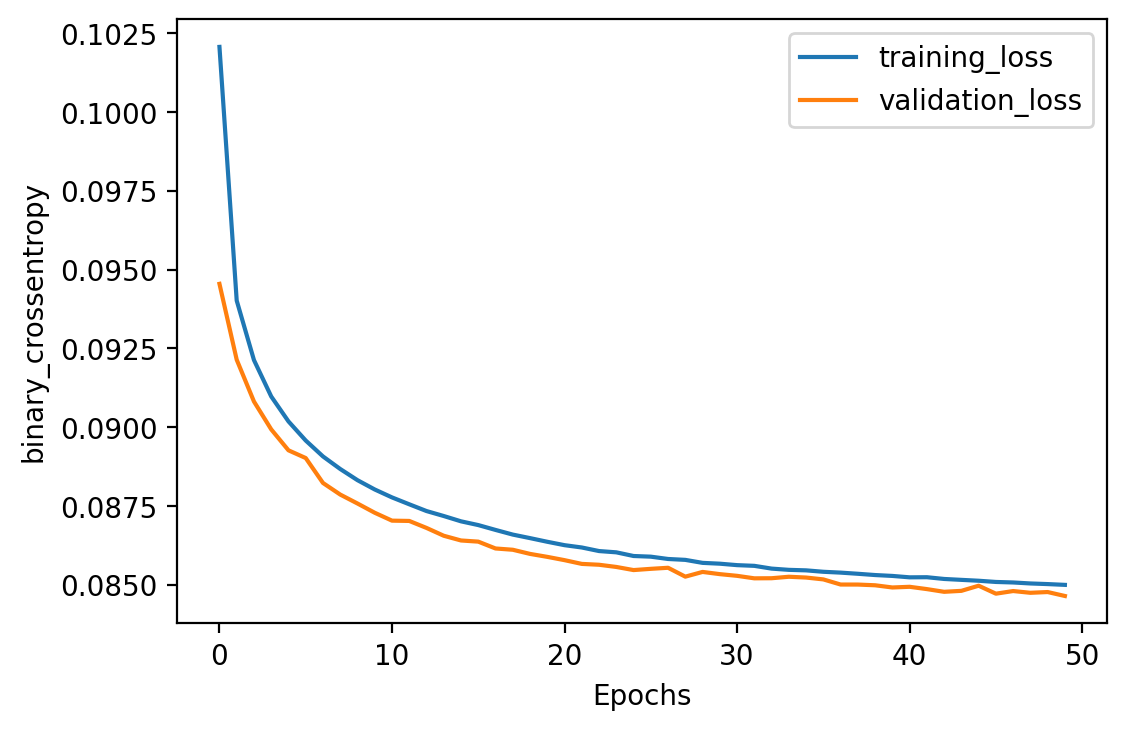

In [71]:
autoencoder.plot_training(history)

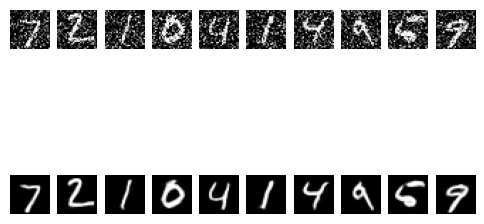

In [91]:
y_pred_orig = autoencoder.predict(noisy_test_data, model)

display(noisy_test_data, y_pred_orig, 2, 10)

In [89]:
# For different noise levels

def test_diff_noise(noise, t_data, v_data):
    
    new_train_data, new_noisy_train_data = preprocess(data=t_data, noise_factor=noise)
    new_test_data, new_noisy_test_data = preprocess(data=v_data, noise_factor=noise)
    
    y_pred_orig = autoencoder.predict(new_noisy_test_data, model)
    display(new_noisy_test_data, y_pred_orig, 2, 10)

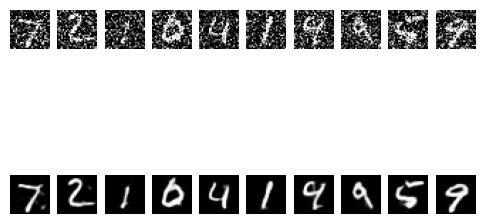

In [96]:
test_diff_noise(0.5, train_data, test_data)

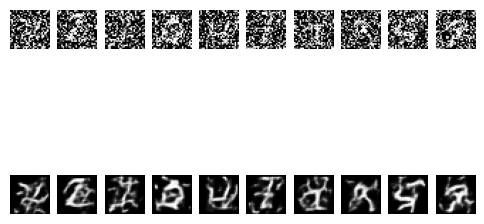

In [97]:
test_diff_noise(0.9, train_data, test_data)

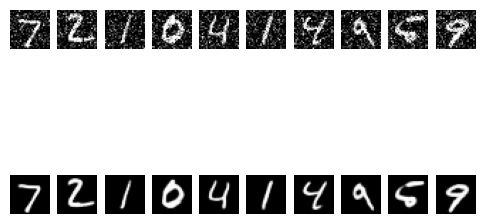

In [98]:
test_diff_noise(0.3, train_data, test_data)

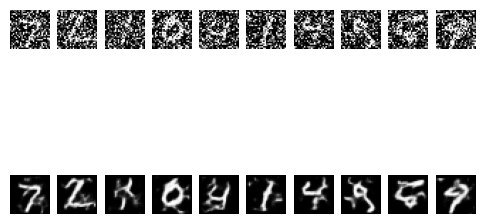

In [99]:
test_diff_noise(0.7, train_data, test_data)